# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [4]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

x_orig [3.]
Gradient check passed!
x_orig [3. 2.]
Gradient check passed!
x_orig [[3. 2.]
 [1. 0.]]
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [5]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))
print(probs, np.sum(probs))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)
print(probs)

[2.06106005e-09 4.53978686e-05 9.99954600e-01] 0.9999999999999999
[1. 0. 0.]


In [6]:
print(probs)

[1. 0. 0.]


Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [7]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
print(probs)
cel = linear_classifer.cross_entropy_loss(probs, 1)
print(cel)

[4.50940412e-05 6.69254912e-03 9.93262357e-01]
5.006760443547122


После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [8]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

x_orig [1. 0. 0.]
Gradient check passed!


True

In [9]:
loss, grad

(1.551444713932051, array([ 0.57611688, -0.78805844,  0.21194156]))

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [10]:
ar= np.array([[1,2,3], [5,1,4], [3,0,7], [1,1,0]])

ar1 = ar - np.max(ar, 1).reshape(1, ar.shape[0]).transpose()
print(np.exp(ar1), np.sum(np.exp(ar1), 1) )
print(np.sum(np.exp(ar1), 1).reshape(4,1).dot(np.ones((1,4))))
print(np.ones((4,1)).shape)
res = linear_classifer.softmax(ar.copy())

lres = -np.log(res[np.arange(0,4), np.array([1, 2, 1, 0])])

print("lres",lres)
#print("log",-np.log(res[:, 1]))

linear_classifer.softmax_with_cross_entropy(ar, np.array([[1, 1, 0, 0]]))

tgi= np.array([[1, 1, 0, 0]])
ar[np.arange(0,4), np.array([1, 2, 1, 0])] -= 1
print(ar)

[[1.35335283e-01 3.67879441e-01 1.00000000e+00]
 [1.00000000e+00 1.83156389e-02 3.67879441e-01]
 [1.83156389e-02 9.11881966e-04 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 3.67879441e-01]] [1.50321472 1.38619508 1.01922752 2.36787944]
[[1.50321472 1.50321472 1.50321472 1.50321472]
 [1.38619508 1.38619508 1.38619508 1.38619508]
 [1.01922752 1.01922752 1.01922752 1.01922752]
 [2.36787944 2.36787944 2.36787944 2.36787944]]
(4, 1)
lres [1.40760596 1.32656264 7.01904501 0.8619948 ]
[[ 1  1  3]
 [ 5  1  3]
 [ 3 -1  7]
 [ 0  1  0]]


In [11]:
a = np.array([[1, 3, 0],
       [0, 0, 0],
       [2, 4, 0],
       [0, 0, 0]])

RR = np.array([0, 1, 2, 3])
CC = np.array([[0, 0, 1, 1]])
print(a[RR,CC])
a[RR, CC] = 1
print(a)

[[1 0 4 0]]
[[1 3 0]
 [1 0 0]
 [2 1 0]
 [0 1 0]]


In [12]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
print(predictions)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
l1, dl1 = linear_classifer.softmax_with_cross_entropy(predictions, target_index)
print(l1, dl1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

print("\n")
# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
l2, dl2 = linear_classifer.softmax_with_cross_entropy(predictions, target_index)
print("l2",l2, "dl2",dl2)
print(target_index)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

[[ 1.  2. -1.  1.]]
3.5797242232074917 [[ 0.20603191  0.56005279 -0.97211661  0.20603191]]
x_orig [[ 1.  2. -1.  1.]]
Gradient check passed!


l2 6.480614761850989 dl2 [[ 0.68145256  0.03392753  0.03392753 -0.74930761]
 [ 0.10923177  0.29692274  0.29692274 -0.70307726]
 [ 0.15216302  0.41362198 -0.97940697  0.41362198]]
[[3]
 [3]
 [2]]
x_orig [[ 2. -1. -1.  1.]
 [ 0.  1.  1.  1.]
 [ 1.  2. -1.  2.]]
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [13]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)

check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

x_orig [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [14]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

x_orig [[ 1.  2.]
 [-1.  1.]
 [ 1.  2.]]
Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [15]:
import linear_classifer

In [16]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = linear_classifer.LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)


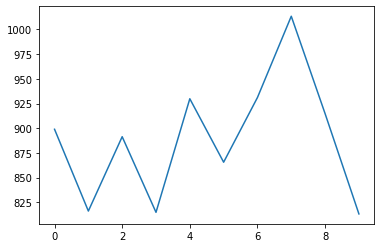

In [17]:
# let's look at the loss history!
plt.plot(loss_history)

Accuracy:  0.15
Accuracy after training for 100 epochs:  0.146


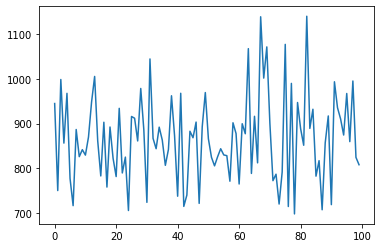

In [18]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
loss_history = classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-3, batch_size=300, reg=1e1)
plt.plot(loss_history)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [19]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
reg_strengths = [1e-4, 1e-5, 1e-6, 1e-7]

best_classifier = None
best_val_accuracy = None
loss_history = None
best_lr = 1e-3
best_reg = 1e-4

for lr in learning_rates:
    for rs in reg_strengths:
        classif = linear_classifer.LinearSoftmaxClassifier()
        lh = classif.fit(train_X, train_y, epochs=100, learning_rate=lr, batch_size=300, reg=rs)
        pred = classif.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if best_classifier == None or best_val_accuracy < accuracy:
            best_classifier = classif
            best_val_accuracy = accuracy
            lh = loss_history
            best_lr = lr
            best_reg = rs

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially



best validation accuracy achieved: 0.251000, learning_rate: 0.000100, reg: 0.000100


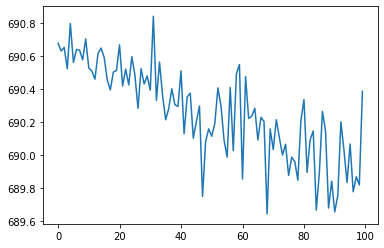

In [20]:
plt.plot(lh)

print('best validation accuracy achieved: %f, learning_rate: %f, reg: %f' % (best_val_accuracy, best_lr, best_reg))

# Какой же точности мы добились на тестовых данных?

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.205000
